In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
device = "mps"
torch.manual_seed(0)
np.random.seed(0)

In [12]:
def generate_data(T, n, S=0.999):
    x = np.zeros((T, n))
    for i in range(T):
        mask = np.random.rand(n) > S
        values = np.random.rand(n) * mask
        x[i] = values
        norm = np.linalg.norm(x[i]) + 1e-8
        x[i] /= norm
    return x

In [13]:
class TiedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TiedAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim, bias=False)
        self.b = nn.Parameter(torch.zeros(input_dim))
    
    def forward(self, x):
        h = self.encoder(x)
        x_recon = torch.relu(torch.matmul(h, self.encoder.weight) + self.b)
        return x_recon

In [21]:
def train_model(model, X_train, X_test, num_epochs=50000, lr=1e-3, weight_decay=1e-2):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    train_loss = 0.0
    test_loss = 0.0
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        
        if epoch == num_epochs - 1:
            with torch.no_grad():
                train_loss = criterion(model(X_train), X_train).item()
                test_loss = criterion(model(X_test), X_test).item()
        
        if epoch % 5000 == 0:
            print(f'Эпоха {epoch}, Train loss: {loss.item()}')
    
    return train_loss, test_loss

In [15]:
n = 10000  # Размерность входных данных
m = 2      # Размерность скрытого слоя
T_list = [5, 30, 100, 1000, 5000]  # Размеры датасета
num_epochs = {5: 50000, 30: 50000, 100: 50000, 1000: 10000, 5000: 10000}  # Меньше эпох для больших T

In [16]:
train_losses = []
test_losses = []

T=5
Эпоха 0, Train loss: 9.999011672334746e-05
Эпоха 5000, Train loss: 1.387994862274422e-12
Эпоха 10000, Train loss: 1.6151246261101627e-14
Эпоха 15000, Train loss: 1.7575659428610058e-15
Эпоха 20000, Train loss: 5.5527681079223495e-15
Эпоха 25000, Train loss: 3.1865409121859933e-15
Эпоха 30000, Train loss: 2.4868184294040037e-15
Эпоха 35000, Train loss: 6.979555720540171e-15
Эпоха 40000, Train loss: 3.3365932223085662e-15
Эпоха 45000, Train loss: 3.0351797244016756e-15
T=30
Эпоха 0, Train loss: 9.997956658480689e-05
Эпоха 5000, Train loss: 6.009958087815903e-05
Эпоха 10000, Train loss: 4.9501642934046686e-05
Эпоха 15000, Train loss: 4.4603104470297694e-05
Эпоха 20000, Train loss: 4.389407695271075e-05
Эпоха 25000, Train loss: 4.379923120723106e-05
Эпоха 30000, Train loss: 4.0917111618909985e-05
Эпоха 35000, Train loss: 4.083354360773228e-05
Эпоха 40000, Train loss: 4.0829672798281536e-05
Эпоха 45000, Train loss: 4.08263731515035e-05
T=100
Эпоха 0, Train loss: 9.998446330428123e-05
Эп

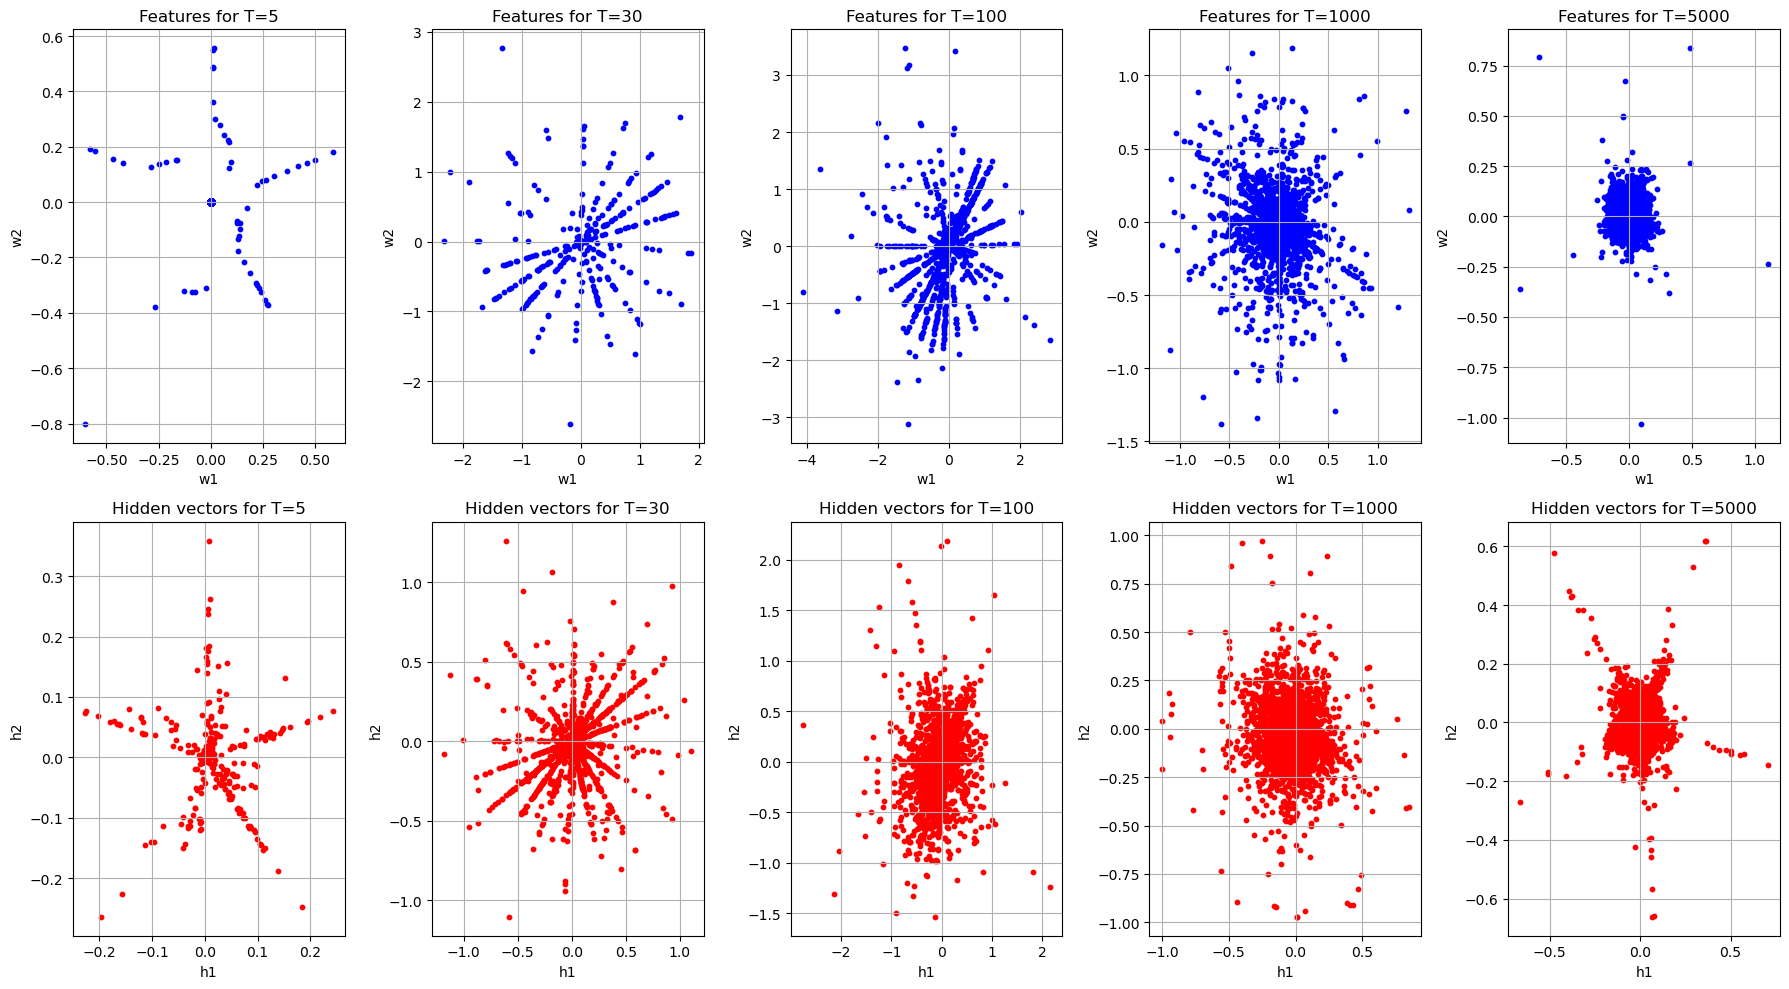

In [22]:
fig, axes = plt.subplots(2, len(T_list), figsize=(18, 10))

for i, T in enumerate(T_list):
    print(f"T={T}")

    X_train_np = generate_data(T, n)
    X_test_np = generate_data(T, n)
    X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)

    model = TiedAutoencoder(input_dim=n, hidden_dim=m).to(device)
    train_loss, test_loss = train_model(model, X_train, X_test, num_epochs=num_epochs[T])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    with torch.no_grad():
        hidden_vecs = model.encoder(X).cpu().numpy()
        features = model.encoder.weight.cpu().numpy().T

    axes[0, i].scatter(features[:, 0], features[:, 1], color='b', s=10)
    axes[0, i].set_title(f"Features for T={T}")
    axes[0, i].set_xlabel("w1")
    axes[0, i].set_ylabel("w2")
    axes[0, i].grid(True)
    
    axes[1, i].scatter(hidden_vecs[:, 0], hidden_vecs[:, 1], color='r', s=10)
    axes[1, i].set_title(f"Hidden vectors for T={T}")
    axes[1, i].set_xlabel("h1")
    axes[1, i].set_ylabel("h2")
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()

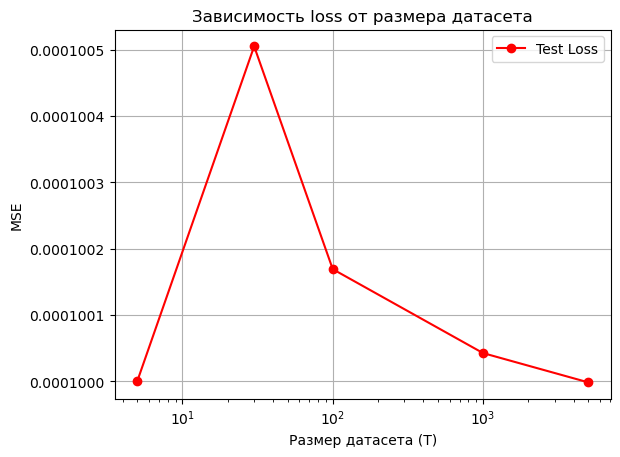

In [26]:
plt.xscale('log')
plt.plot(T_list, test_losses, marker='o', label='Test Loss', color='red')
plt.title("Зависимость loss от размера датасета")
plt.xlabel("Размер датасета (T)")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()